In [1]:
#https://github.com/monocongo/climate_learn
import glob

import netCDF4
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors as c
%matplotlib inline
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy.cluster.vq import *
from mpl_toolkits.axes_grid1 import make_axes_locatable
import nc_time_axis
import cftime

from scipy.spatial import distance
# from skimage import measure

xr.set_options(display_style='text')

from eofs.xarray import Eof
#===========EOF
from packages import *
import EOFsfunction 
# import weighted_SM_average

#===========Plotters
import cartopy as cart
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point

In [2]:
#============SOM
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
from sklearn.preprocessing import MinMaxScaler, scale
import numpy as np
from minisom import MiniSom

### Get a list of all files available in folders for CLM5 model simulations

In [3]:
CLM5_Exp1 = glob.glob("/scratch/leaf/SP-MIP/CLM5_experiment_1*")
CLM5_Exp2 = glob.glob("/scratch/leaf/SP-MIP/CLM5_experiment_2*")
CLM5_Exp3 = glob.glob("/scratch/leaf/SP-MIP/CLM5_experiment_3*")
CLM5_Exp4a = glob.glob("/scratch/leaf/SP-MIP/CLM5_experiment_4a*")
CLM5_Exp4b = glob.glob("/scratch/leaf/SP-MIP/CLM5_experiment_4b*")
CLM5_Exp4c = glob.glob("/scratch/leaf/SP-MIP/CLM5_experiment_4c*")
CLM5_Exp4d = glob.glob("/scratch/leaf/SP-MIP/CLM5_experiment_4d*")

us_lat_bounds = (24.0, 50.0)
us_lon_bounds = (360-126.0, 360-66.0)
landmask = xr.open_mfdataset(CLM5_Exp1).sel(lat=slice(*us_lat_bounds), lon=slice(*us_lon_bounds)).landmask

data_CLM5_Exp1 = xr.open_mfdataset(CLM5_Exp1).sel(lat=slice(*us_lat_bounds), lon=slice(*us_lon_bounds))*landmask
data_CLM5_Exp2 = xr.open_mfdataset(CLM5_Exp2).sel(lat=slice(*us_lat_bounds), lon=slice(*us_lon_bounds))*landmask
data_CLM5_Exp3 = xr.open_mfdataset(CLM5_Exp3).sel(lat=slice(*us_lat_bounds), lon=slice(*us_lon_bounds))*landmask
data_CLM5_Exp4a = xr.open_mfdataset(CLM5_Exp4a).sel(lat=slice(*us_lat_bounds), lon=slice(*us_lon_bounds))*landmask
data_CLM5_Exp4b = xr.open_mfdataset(CLM5_Exp4b).sel(lat=slice(*us_lat_bounds), lon=slice(*us_lon_bounds))*landmask
data_CLM5_Exp4c = xr.open_mfdataset(CLM5_Exp4c).sel(lat=slice(*us_lat_bounds), lon=slice(*us_lon_bounds))*landmask
data_CLM5_Exp4d = xr.open_mfdataset(CLM5_Exp4d).sel(lat=slice(*us_lat_bounds), lon=slice(*us_lon_bounds))*landmask

In [4]:
data_CLM5_Exp1.landmask

<xarray.DataArray 'landmask' (time: 11315, lat: 52, lon: 120)>
dask.array<mul, shape=(11315, 52, 120), dtype=float32, chunksize=(365, 52, 120), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 1980-01-02 00:00:00 ... 2011-01-01 00:00:00
  * lon      (lon) float32 234.2 234.8 235.2 235.8 ... 292.2 292.8 293.2 293.8
  * lat      (lat) float32 24.25 24.75 25.25 25.75 ... 48.25 48.75 49.25 49.75

In [5]:
lat = np.arange(data_CLM5_Exp1.lat.min(), data_CLM5_Exp1.lat.max(), 0.5)
lon = np.arange(data_CLM5_Exp1.lon.min(), data_CLM5_Exp1.lon.max(), 0.5)

# Experiment 1, 2, 3 CLM Model Runs

### Exp-1 Identical Soil Parameter Maps
- Global soil hydraulic parameter maps provided by SP-MIP

### Exp-2 Identical Soil Texture Maps
- Global soil texture maps provided by SP-MIP
- hydraulic parameters are derived by the modelling groups 

### Exp-3 Identical Soil Texture Maps
- The model is run with default soil paramters

## Empirical Orthogonal Function Analysis (EOF)

In [6]:
#=========================== Computing the annual mean 
exp1_mrlsl = data_CLM5_Exp1.mrlsl.sel(levsoi=slice(0,12)).mean('levsoi')#.groupby('time.year').mean('time').isel()*0.3715504356225332
exp2_mrlsl = data_CLM5_Exp2.mrlsl.sel(levsoi=slice(0,12)).mean('levsoi')#.groupby('time.year').mean('time').isel()*0.3913808739185334
exp3_mrlsl = data_CLM5_Exp3.mrlsl.sel(levsoi=slice(0,12)).mean('levsoi')#.groupby('time.year').mean('time').isel()*0.38882259051005047

#=========================== Decomposing SPMIP soil moisture data experiment 1-3 
n_eof = 32 #number of EOFs considered
eofs1, pcs1, var_fracs1, lambdas1, eofs_corr1, eof_corrpcs1, reconstruction1 = EOFsfunction.Emp_Ortho_Funcs(exp1_mrlsl, n_eof)
# eofs2, pcs2, var_fracs2, lambdas2, eofs_corr2, eof_corrpcs2,reconstruction2 = EOFsfunction.Emp_Ortho_Funcs(exp2_mrlsl, n_eof)
# eofs3, pcs3, var_fracs3, lambdas3, eofs_corr3, eof_corrpcs3,reconstruction3 = EOFsfunction.Emp_Ortho_Funcs(exp3_mrlsl, n_eof)

....Checking Setting Weighting...
....Decomposing Modes of SPMIP Data...
...Correlating.....


In [48]:
def make_contour_plot(eofs, var_fracs, ax_index, title):
    #=================== Choose the Multi-model ensemble (MME) and week1 (time index of 0)
    data, lons = add_cyclic_point(eofs, coord=exp1_mrlsl['lon'])

    #=================== Make a filled contour plot
    cs = ax[ax_index].contourf(lons, exp1_mrlsl['lat'], data, transform=ccrs.PlateCarree(),
                               cmap='RdBu_r', extend='both')
    states = cfeature.NaturalEarthFeature(category='cultural',
                                      name='admin_1_states_provinces_lines',scale='50m',facecolor='none')
    ax[ax_index].add_feature(states, edgecolor='gray')
    ax[ax_index].set_title(title, fontweight='bold', fontsize=10, loc='left')
    ax[ax_index].set_title(f"Expl. Var. {(var_fracs*100).round(2)}%", loc='right', fontweight='bold', size=10)

    #=================== Add coastlines
    ax[ax_index].coastlines()
    #ax[ax_index].gridlines(alpha=0.5)

    #=================== Define the xticks for longitude
    ax[ax_index].set_xticks(np.arange(-126, -66, 10), crs=ccrs.PlateCarree())
    lon_formatter = cticker.LongitudeFormatter()
    ax[ax_index].xaxis.set_major_formatter(lon_formatter)

    #=================== Define the yticks for latitude
    ax[ax_index].set_yticks(np.arange(24, 50, 5), crs=ccrs.PlateCarree())
    lat_formatter = cticker.LatitudeFormatter()
    ax[ax_index].yaxis.set_major_formatter(lat_formatter)

    ax[ax_index].add_feature(cfeature.BORDERS, linestyle='-')
    ax[ax_index].add_feature(cfeature.COASTLINE)
    ax[ax_index].add_feature(cfeature.OCEAN,color='lightgrey')

    return cs

# #===========================Average variance explained for experiment 4a-d modes
# EOFs14_aver_var_Explained = (100*var_fracs3[0]+100*var_fracs3[0]+100*var_fracs3[0]+100*var_fracs3[0])/4
# EOFs24_aver_var_Explained = (100*var_fracs3[1]+100*var_fracs3[1]+100*var_fracs3[1]+100*var_fracs3[1])/4

#============================================EOF Time Series 
def plot_eofs_over_time(years, eof_amplitudes, eof_labels, title, xlabel, ylabel):
    plt.figure(figsize=(14,3))
    for i in range(len(eof_amplitudes)):
#         plt.plot(years, np.delete(eof_amplitudes[i],-1), label=eof_labels[i], linewidth=3, linestyle='dashed', marker="o")
        plt.plot(years, eof_amplitudes[i], label=eof_labels[i], linewidth=2, linestyle='dashed')
    plt.xlabel(xlabel, fontweight='bold', fontsize=12)
    plt.ylabel(ylabel, fontweight='bold', fontsize=12)
    plt.title(title, fontweight='bold', loc='left', size=12)
    plt.legend(loc="upper right", fontsize=8)
    plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
    plt.axhline(0, color='k')
    plt.minorticks_on()
    plt.grid(linestyle=':', linewidth=0.5, color='k')
    plt.subplots_adjust(left=-0.19, right=0.8, top=0.8, bottom=0.1)
    plt.show()
    

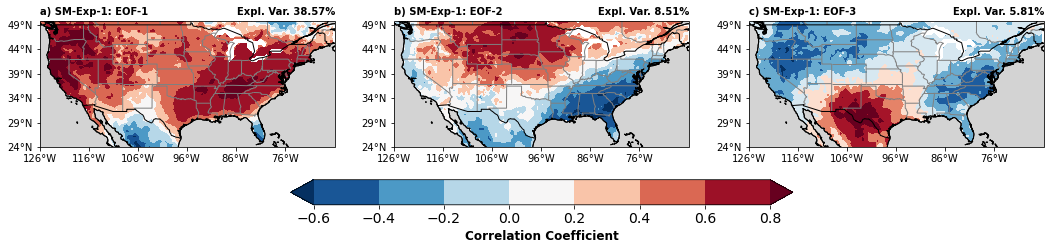

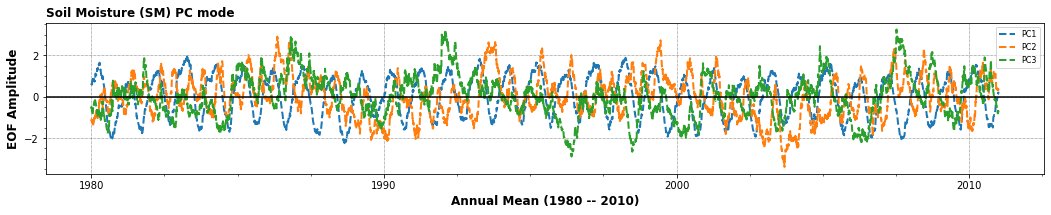

In [49]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=[18,6], subplot_kw={'projection': ccrs.PlateCarree()}, gridspec_kw={'wspace':.2, 'hspace':.22})

#============================================ EOF Spatial Correlation Maps 
cs1 = make_contour_plot(eofs_corr1[0,:,:], var_fracs1[0], 0, 'a) SM-Exp-1: EOF-1')
cs2 = make_contour_plot(eofs_corr1[1,:,:], var_fracs1[1], 1, 'b) SM-Exp-1: EOF-2')
cs3 = make_contour_plot(eofs_corr1[2,:,:], var_fracs1[2], 2, 'c) SM-Exp-1: EOF-3')
#======================== Create colorbar
cbar = plt.colorbar(cs1, ax=ax.ravel().tolist(), orientation='horizontal', shrink=.5, extend='both', pad=0.099)
cbar.ax.tick_params(labelsize=14)
cbar.set_label('Correlation Coefficient',fontweight='bold', fontsize=12)

#============================================ EOF Time Series 
# years = np.arange(1980, 2011, 1)
time = exp1_mrlsl.time
eof_amplitudes = [pcs1[:,0], pcs1[:,1], pcs1[:,2]]
eof_labels = ["PC1", "PC2", "PC3"]
title = "Soil Moisture (SM) PC mode"
xlabel = "Annual Mean (1980 -- 2010)"
ylabel = "EOF Amplitude"
plot_eofs_over_time(time , eof_amplitudes, eof_labels, title, xlabel, ylabel)

fig.savefig('myplot.png')

The PC1, also known as the first Principal Component, corresponds to the EOF1, which stands for Empirical Orthogonal Function 1. The PC1 represents the most dominant mode of variability in the data set, capturing the largest amount of variation and contributing significantly to the overall pattern. It is derived through a mathematical process that combines the weights assigned to different variables or observations with the spatial patterns represented by the EOF1. In other words, the PC1 provides a numerical representation of the spatial structure and magnitude of the variability associated with the EOF1. By analyzing the PC1, researchers can gain insights into the primary patterns and features that influence the data set, helping to identify key drivers and understand the underlying processes driving the observed phenomena.

## Integratint the EOF modes into the Self-organizing map (SOM)

Applying `np.nan_to_num(eofs1)`, we are converting all NaN values in the array `eofs1` to zeros, effectively removing the NaN values from the data. The resulting array `sm_eof_mode` will have NaN values replaced with zeros, making it suitable for further calculations or analysis that may require complete numerical data to be utilized by the self-organizing map (SOM).


In [56]:
sm_eof_mode = np.nan_to_num(eofs1) #------------- replacing NaN with zeros
sm_eof_mode.shape #------------- shape of the eof mode 

(32, 52, 120)

In [67]:
sm_eof_mode_ = sm_eof_mode.reshape(-1, 120) #------------ Reshape the data to a 2D array of (1664,120)
sm_eof_mode_.shape

(1664, 120)

In [60]:
#=================Define SOM parameters=========================#
som_map = (3,4) #=============== we will try a 3x3 neural map
x,y= som_map
sigma = 0.9 #============ default value
learning_rate = 1 #============= default value
ngb_function = 'gaussian' #============ choosing between ['gaussian' ,'bubble','mexican_hat']
init = 'random' #============= we will initialize SOM randomly. Option: 'pca'
train = 'batch' #========== perform batch traning instead of random (default)
iterations = 10000 #=========== length of training
topology = 'hexagonal' #============ to ensure equidistant ditance neighbors
activation_distance = 'euclidean'

In [71]:
X =  sm_eof_mode_  #============= reshaped_eof_modes
input_len = X.shape[1]

#=========== Initialize and train the SOM
som = MiniSom(x=x,y=y,input_len=input_len,
                    sigma=sigma,learning_rate=learning_rate,
                    neighborhood_function=ngb_function,
                    topology=topology,
                    activation_distance=activation_distance,
                    random_seed=None)
if init=='pca':
    som.pca_weights_init(X)
else:
    som.random_weights_init(X)

#=========== train som
if train=='random':
    som.train_random(X,iterations,verbose=True)
else:
    som.train_batch(X,iterations,verbose=True)

 [ 10000 / 10000 ] 100% - 0:00:00 left 
 quantization error: 0.005541209252787767


Requested network: 3x4
 Identified: 12 time modes


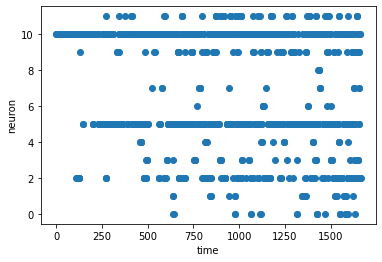

In [104]:
# extract clusters of winning neurons:
# each neuron represents a cluster
winner_coordinates = np.array([som.winner(x) for x in X]).T
# with np.ravel_multi_index we convert the bidimensional
# coordinates to a monodimensional index
cluster_index = np.ravel_multi_index(winner_coordinates, (x,y))
# cluster_index=winner_coordinates[1,:]
n_cluster=len(np.unique(cluster_index))
print('Requested network: {}x{}\n Identified: {} time modes'.format(x,y,n_cluster))
plt.scatter(range(sm_eof_mode_.shape[0]),cluster_index)
plt.ylabel('neuron')
plt.xlabel('time')
plt.show()

In [72]:
#============== Compute the U-matrix
u_matrix = som.distance_map()

In [76]:
component.shape

(4, 120)

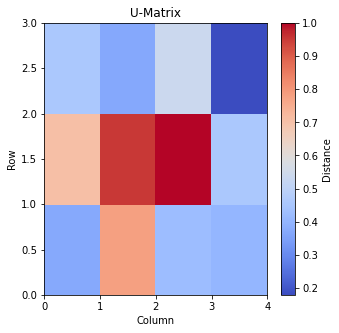

In [82]:
#=============== Visualize the U-matrix
plt.figure(figsize=(5, 5))
plt.pcolor(u_matrix, cmap='coolwarm')
# Add colorbar
cbar = plt.colorbar()
cbar.set_label('Distance')
# Set axis labels and title
plt.xlabel('Column')
plt.ylabel('Row')
plt.title('U-Matrix')
plt.show()

The U-matrix is a common visualization technique used to interpret the results of a Self-Organizing Map (SOM). It provides insights into the topological organization and cluster structure of the SOM grid. Each cell in the U-matrix represents the average distance between a neuron and its neighboring neurons in the SOM grid.

When interpreting the U-matrix, you can look for the following characteristics:

1. Distance between neighboring neurons: The color intensity or value in each cell of the U-matrix represents the distance between a neuron and its neighbors. Darker colors or lower values indicate smaller distances, suggesting that the neurons in that region are more similar to each other.

2. Cluster boundaries: In the U-matrix, you can identify areas where the distance between neighboring neurons is higher, indicated by lighter colors or higher values. These regions represent cluster boundaries or areas where the data transitions from one cluster to another.

3. Smooth regions: Smooth, low-variance regions in the U-matrix indicate areas of homogeneous clusters, where the data points are relatively similar to each other. These regions are typically represented by darker colors or lower values.

4. Disrupted regions: Disrupted or irregular patterns in the U-matrix suggest areas of higher variance or transitions between different clusters. These regions might indicate areas where the data points are more dissimilar or ambiguous.

5. Cluster shape and size: The shape and size of the darker regions in the U-matrix can provide insights into the cluster structure. Larger and elongated regions may indicate larger clusters or clusters with similar characteristics. Smaller, isolated regions might suggest smaller or more distinct clusters.

### Extract time series of each cluster

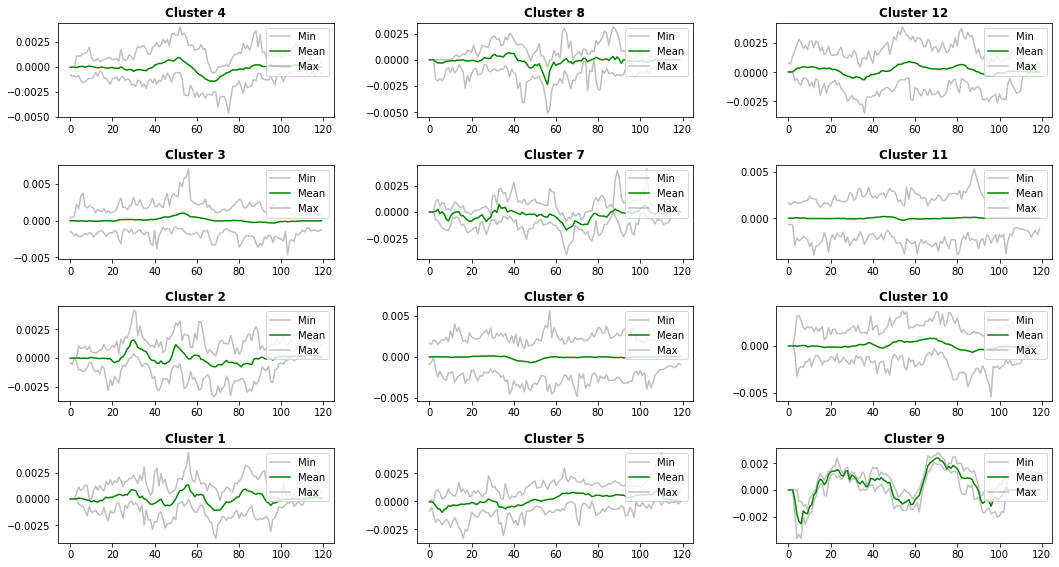

In [102]:
#=========== extract time series of each cluster
win_map = som.win_map(X)
win_ts = np.zeros((len(win_map), input_len, 3))

#========== Cluster_index = np.ravel_multi_index(win_ts, (x, y))

#========= Plot time series
plt.figure(figsize=(50, 20))
the_grid = GridSpec(8, 8)

#========= Sort the clusters based on their keys in descending order
sorted_clusters = sorted(win_map.keys(), reverse=True)

for i, position in enumerate(sorted_clusters):
    win_ts[i, :, 0] = np.min(win_map[position], axis=0)
    win_ts[i, :, 1] = np.mean(win_map[position], axis=0)
    win_ts[i, :, 2] = np.max(win_map[position], axis=0)

    ax = plt.subplot(the_grid[6 - position[1], position[0]])
    ax.plot(np.min(win_map[position], axis=0), color='gray', alpha=.5, linewidth=1.5, label='Min')
    ax.plot(np.mean(win_map[position], axis=0),color='green', linewidth=1.5, label='Mean')
    ax.plot(np.max(win_map[position], axis=0), color='gray', linewidth=1.5, alpha=.5, label='Max')

    #========= Add legend
    ax.legend(loc="upper right", fontsize=10)

    #========= Add title to each subplot
    ax.set_title(f'Cluster {len(win_map) - i}',fontweight='bold')  #========= Adjust index to start from 1 at the bottom

plt.subplots_adjust(hspace=0.5, wspace=0.3)    
plt.show()


The provided code generates a grid of subplots, where each subplot represents a cluster. The time series of each cluster are plotted in three lines: minimum values in gray (labeled as "Min"), mean values (labeled as "Mean"), and maximum values in gray (labeled as "Max"). The clusters are sorted based on their keys in descending order, and the subplots are arranged accordingly.

The interpretation of the plot is as follows:
- Each subplot represents a cluster identified by the Self-Organizing Map (SOM).
- The x-axis represents the logitude in the data.
- The y-axis represents the values of the data.
- The lines in each subplot show the variation of the data within the cluster.
  - The gray lines represent the minimum and maximum values of the data within the cluster.
  - The colored line represents the mean value of the data within the cluster.
- The legend on each subplot explains the color-coding of the lines.

By examining the plot, you can observe the patterns and variations within each cluster. Clusters with similar patterns or behaviors will have similar shapes in their time series plots. The clustering helps identify groups of data points with similar characteristics, allowing for further analysis or insights into the underlying data structure.

In [18]:
#https://github.com/NCAR/MSMIP/tree/master/jupyternotebooks